In [ ]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images
#
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#For Keras model
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing import image
import tensorflow as tf
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Dataset Preparation

In [ ]:
path = "/content/drive/My Drive/"
annot = "/content/drive/My Drive/annotations.json"

In [ ]:
# Read Annotations
with open(annot , 'r') as f:
    dataset = json.loads(f.read())

In [ ]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [ ]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [ ]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [ ]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [ ]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [ ]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [ ]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,517.0,127.0,447.0,1322.0
1,batch_1/000012.jpg,Glass bottle,379.0,1127.0,425.0,318.0
2,batch_1/000048.jpg,Glass bottle,211.0,1.0,417.0,1417.0
3,batch_1/000021.jpg,Glass bottle,852.0,638.0,687.0,291.0
4,batch_1/000022.jpg,Glass bottle,647.0,1033.0,820.0,376.0


In [ ]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

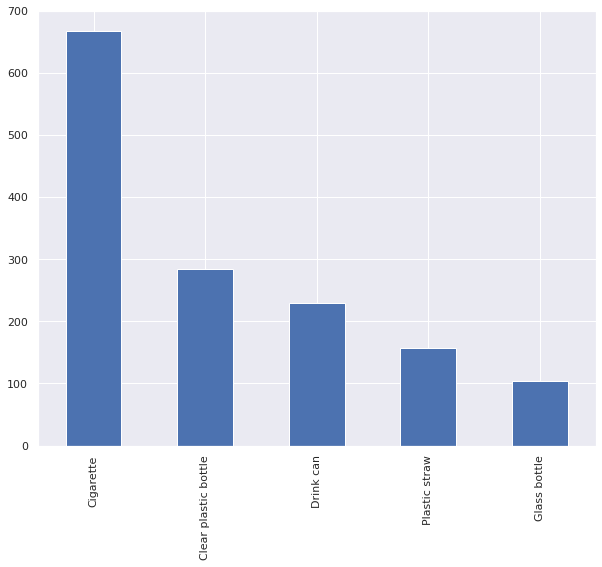

In [ ]:
df['category'].value_counts().plot.bar()

Fetch, crop and store image data

In [ ]:
# path of the folder containing the original images 
inPath = path+'data' 
# path of the folder that will contain the cropped image 
outPath = path+'trainDataTACO' 
train_data = []  
for ind in df.index:
  bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
  imagePath = os.path.join(inPath+'/'+df['filename'][ind])
  img = Image.open(imagePath)
  img = img.crop(bbox)
  fullOutPath = os.path.join(outPath +'/'+df['filename'][ind]) 
  img.save(fullOutPath)

In [ ]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)
df = df.astype({"category":'category'})
df.head()

,filename,category
0,batch_1/000006.jpg,Glass bottle
1,batch_1/000012.jpg,Glass bottle
2,batch_1/000048.jpg,Glass bottle
3,batch_1/000021.jpg,Glass bottle
4,batch_1/000022.jpg,Glass bottle


Data Split

In [ ]:
# Data split Randomly
trainData_df, testData_df = train_test_split(df, test_size=0.20, random_state=41)

In [ ]:
print(trainData_df.shape)
print(testData_df.shape)

(1153, 2)
(289, 2)


In [ ]:
trainData_df['category'].value_counts()

Cigarette               527
Clear plastic bottle    235
Drink can               180
Plastic straw           123
Glass bottle             88
Name: category, dtype: int64

In [ ]:
# Fixed for our 'Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle' classes
NUM_CLASSES = 5
CHANNELS = 3

# Model parameters
IMAGE_RESIZE = 224
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
input_shape = (IMAGE_RESIZE,IMAGE_RESIZE,CHANNELS)

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 50

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 50
BATCH_SIZE_VALIDATION = 50

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1


In [ ]:
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(validation_split=0.10, rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [ ]:
# Train image data generator
# Create new train folder directory which should have images
newPath = path +'trainDataTACO'
train_generator=data_generator.flow_from_dataframe(
    dataframe=trainData_df,
    directory=newPath,
    x_col="filename",
    y_col="category",
    subset="training",
    batch_size=BATCH_SIZE_TRAINING,
    seed=41,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 1038 validated image filenames belonging to 5 classes.


In [ ]:
# Validation image data generator
validation_generator=data_generator.flow_from_dataframe(
    dataframe=trainData_df,
    directory=newPath,
    x_col="filename",
    y_col="category",
    subset="validation",
    batch_size=BATCH_SIZE_VALIDATION,
    seed=41,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 115 validated image filenames belonging to 5 classes.


In [ ]:
# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = train_generator.n//train_generator.batch_size
STEPS_PER_EPOCH_VALIDATION =  validation_generator.n//validation_generator.batch_size

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation=DENSE_LAYER_ACTIVATION))


In [ ]:
#Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)       

In [ ]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = ['accuracy'])

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

In [ ]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data = validation_generator,
        validation_steps = STEPS_PER_EPOCH_VALIDATION,
        callbacks = [cb_early_stopper]
)

Epoch 1/100
20/20 [==============================] - 17s 868ms/step - loss: 2.2846 - accuracy: 0.3451 - val_loss: 8.0893 - val_accuracy: 0.4300
Epoch 2/100
20/20 [==============================] - 16s 800ms/step - loss: 1.5741 - accuracy: 0.4636 - val_loss: 9.8009 - val_accuracy: 0.5077
Epoch 3/100
20/20 [==============================] - 15s 741ms/step - loss: 1.4855 - accuracy: 0.5030 - val_loss: 7.0662 - val_accuracy: 0.4462
Epoch 4/100
20/20 [==============================] - 16s 806ms/step - loss: 1.4313 - accuracy: 0.5304 - val_loss: 4.1025 - val_accuracy: 0.4800
Epoch 5/100
20/20 [==============================] - 16s 804ms/step - loss: 1.3904 - accuracy: 0.5374 - val_loss: 3.6620 - val_accuracy: 0.4154
Epoch 6/100
20/20 [==============================] - 14s 713ms/step - loss: 1.4306 - accuracy: 0.5324 - val_loss: 1.9173 - val_accuracy: 0.4462
Epoch 7/100
20/20 [==============================] - 16s 814ms/step - loss: 1.3127 - accuracy: 0.5526 - val_loss: 2.7550 - val_accuracy:

In [ ]:
# test image data generator
test_generator=data_generator.flow_from_dataframe(
    dataframe=testData_df,
    directory=newPath,
    x_col="filename",
    y_col=None,
    batch_size=BATCH_SIZE_TESTING,
    seed=41,
    shuffle=False,
    class_mode=None,
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 289 validated image filenames.


In [ ]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

289/289 [==============================] - 4s 15ms/step


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
sorting = (-pred).argsort()
# getting the top 5 predictions
sorted_ = sorting[0][:5]
# Prediction for all the classes
for value in sorted_:
  predicted_label = labels[value]
  # Rounding steps
  prob = (pred[0][value]) * 100
  prob = "%.2f" % round(prob,2)
  print("Prediction is that %s%% of Data belongs to %s." % (prob, predicted_label))

{0: 'Cigarette',
 1: 'Clear plastic bottle',
 2: 'Drink can',
 3: 'Glass bottle',
 4: 'Plastic straw'}

Used 'Adam' optimizer instead of SGD

In [ ]:
model.compile(optimizer = 'adam', loss = OBJECTIVE_FUNCTION, metrics = ['accuracy'])

In [ ]:
fit_history_adam = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data = validation_generator,
        validation_steps = STEPS_PER_EPOCH_VALIDATION,
        callbacks = [cb_early_stopper]
)

Epoch 1/100
20/20 [==============================] - 17s 869ms/step - loss: 1.4474 - accuracy: 0.5992 - val_loss: 2.2470 - val_accuracy: 0.6400
Epoch 2/100
20/20 [==============================] - 16s 820ms/step - loss: 1.1848 - accuracy: 0.6154 - val_loss: 2.2126 - val_accuracy: 0.5692
Epoch 3/100
20/20 [==============================] - 15s 732ms/step - loss: 1.1331 - accuracy: 0.6235 - val_loss: 1.0306 - val_accuracy: 0.5692
Epoch 4/100
20/20 [==============================] - 16s 815ms/step - loss: 0.9950 - accuracy: 0.6530 - val_loss: 1.6603 - val_accuracy: 0.6600
Epoch 5/100
20/20 [==============================] - 16s 810ms/step - loss: 0.9198 - accuracy: 0.6834 - val_loss: 1.5873 - val_accuracy: 0.5385
Epoch 6/100
20/20 [==============================] - 15s 735ms/step - loss: 0.9725 - accuracy: 0.6872 - val_loss: 0.9467 - val_accuracy: 0.6462
Epoch 7/100
20/20 [==============================] - 16s 818ms/step - loss: 0.8910 - accuracy: 0.7045 - val_loss: 1.5832 - val_accuracy:

In [ ]:
print(fit_history_adam.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


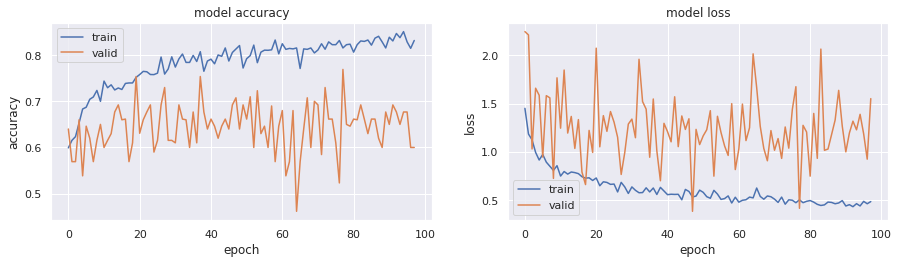

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history_adam.history['accuracy'])  
plt.plot(fit_history_adam.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history_adam.history['loss'])  
plt.plot(fit_history_adam.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

289/289 [==============================] - 4s 15ms/step


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
sorting = (-pred).argsort()
# getting the top 5 predictions
sorted_ = sorting[0][:5]
# Prediction for All the classes
for value in sorted_:
  predicted_label = labels[value]
  # Rounding steps
  prob = (pred[0][value]) * 100
  prob = "%.2f" % round(prob,2)
  print("Prediction is that %s%% of Data belongs to %s." % (prob, predicted_label))

Prediction is that 96.60% of Data belongs to Cigarette.
Prediction is that 1.93% of Data belongs to Plastic straw.
Prediction is that 0.72% of Data belongs to Clear plastic bottle.
Prediction is that 0.56% of Data belongs to Drink can.
Prediction is that 0.19% of Data belongs to Glass bottle.
